<a href="https://colab.research.google.com/github/Dicere/WB_Internship/blob/main/0_3_0_Model_CV_Params_threshold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost

In [51]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, recall_score, precision_recall_curve,precision_score, precision_recall_fscore_support
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold


In [52]:
df = pd.read_csv('/content/drive/MyDrive/WB_стажировка/wb_school_task_2.csv.gzip',compression='gzip')
df = df.drop_duplicates()

In [53]:
cat_feat = ['text']
feature=df[df.columns[3:]].columns

In [54]:
X = df[feature].drop(columns=['label','text'])
y = df['label']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [55]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
indx_all = X_train.index

oof = pd.DataFrame(data=np.zeros((len(indx_all),1)), index=indx_all)
params_grid = {'bootstrap_type': 'MVS',
        'iterations': 800,
        'learning_rate': 0.259,
        'max_depth': 3,
        'objective': 'Logloss',
        'verbose': 200,
        'eval_metric': 'AUC',
        'border_count': 32,
        'colsample_bylevel': 0.09715577437674092,
        'min_data_in_leaf': 20,
        'random_strength': 0.36494249753665964,
        'scale_pos_weight': 0.4366210135974975
        }

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
models=[]
for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    print('#'*25)
    print('### CV_Fold',idx+1)
    print('#'*25)
            
    X_train_сv, X_val_сv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_сv, y_val_сv = y_train.iloc[train_idx], y_train.iloc[test_idx]
 
    clf = CatBoostClassifier(**params_grid)
    clf.fit(X_train_сv.astype('float32'), y_train_сv,
            eval_set=[ (X_val_сv.astype('float32'), y_val_сv) ],
            verbose=0)
    models.append(clf)
    oof.loc[X_val_сv.index,0] = clf.predict_proba(X_val_сv.astype('float32'))[:,1]
    y_pred_metki = clf.predict(X_val_сv)
    y_pred = clf.predict_proba(X_val_сv)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val_сv, y_pred)
    print("AUC_ROC----"+str(roc_auc_score(y_val_сv, y_pred)))
    print("F1-score-----"+str(f1_score(y_val_сv, y_pred_metki,average='macro')))

#########################
### CV_Fold 1
#########################
AUC_ROC----0.728009542451676
F1-score-----0.5640277819537569
#########################
### CV_Fold 2
#########################
AUC_ROC----0.7391118179593835
F1-score-----0.572762898140782
#########################
### CV_Fold 3
#########################
AUC_ROC----0.72374769985688
F1-score-----0.5925727799988738
#########################
### CV_Fold 4
#########################
AUC_ROC----0.7483745655285218
F1-score-----0.5729454622567917
#########################
### CV_Fold 5
#########################
AUC_ROC----0.7389695358822326
F1-score-----0.5608442720763723


In [133]:
def preds_on_all_model(x_test,threshold,models):
  preds=[]
  averages = []
  for model in models:
    preds.append(model.predict_proba(x_test)[:, 1])
  for elements in zip(*preds):
    average = sum(elements) / len(elements)
    averages.append(average)
  y_pred_metki = (averages> threshold).astype('int')
  return y_pred_metki,averages

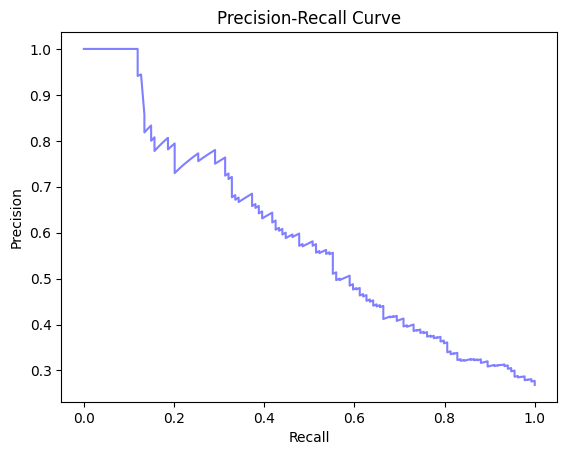

In [56]:
plt.plot(recall, precision, color='b', alpha=0.5)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

###Выбор порога под максимальный f1

In [ ]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0
true = y_train
for threshold in np.arange(0.05,0.97,0.001):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

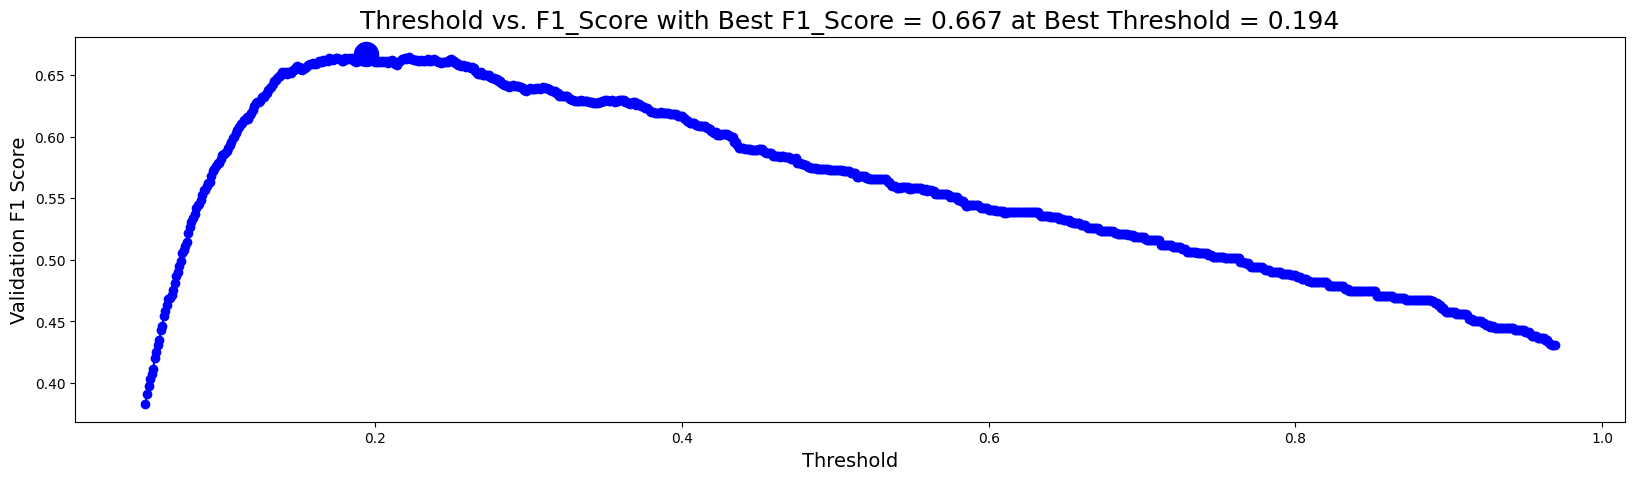

In [122]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [134]:
y_pred_metki_on_avg,y_pred_avg = preds_on_all_model(X_test,best_threshold,models)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_metki_on_avg, average='macro')
roc = roc_auc_score(y_test, y_pred_avg)
print("AUC_ROC----"+str(roc))
print("F1-score-----"+str(f1))
print("Precision-----"+str(precision))
print("Recall-----"+str(recall))

AUC_ROC----0.7568222374742621
F1-score-----0.6741724384691852
Precision-----0.6670178941141673
Recall-----0.6860329444063143


###Выбор порога под максимальный Presicion

In [ ]:
scores = []; thresholds = []
best_score = 0; best_threshold_precision = 0
true = y_train
for threshold in np.arange(0.05,0.97,0.001):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    precision, recall, f1, _ = precision_recall_fscore_support(true.values.reshape((-1)), preds, average='macro')
    scores.append(precision)
    thresholds.append(threshold)
    if precision>best_score:
        best_score = precision
        best_threshold_precision = threshold

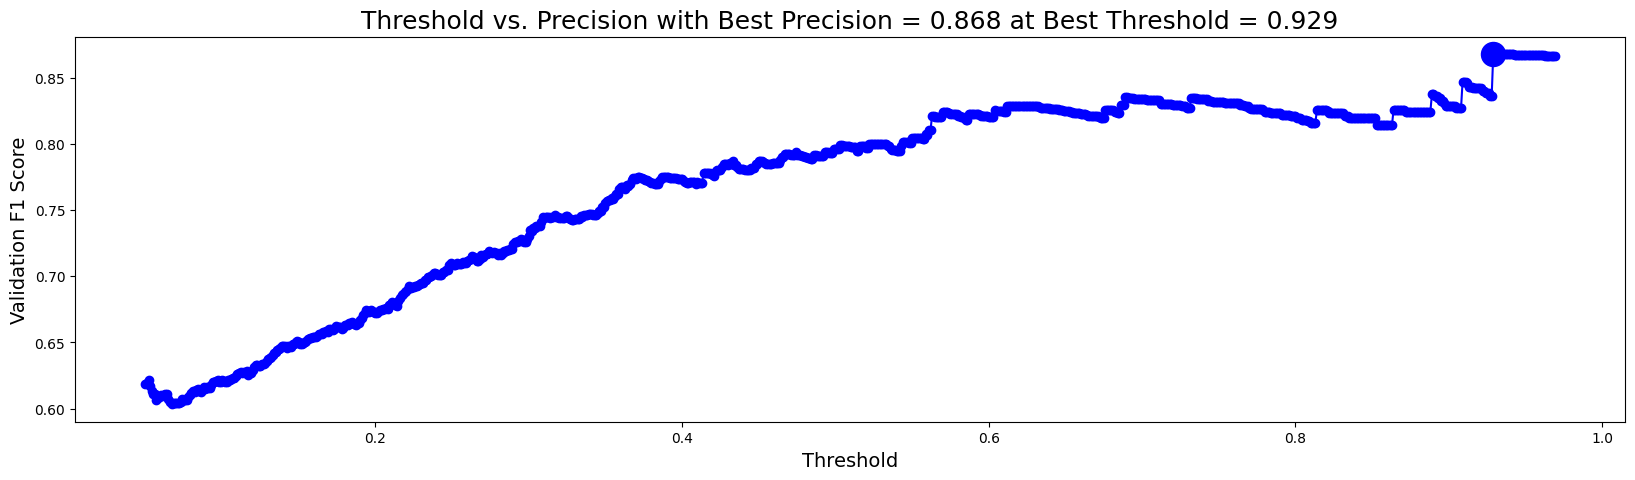

In [136]:
# PLOT THRESHOLD VS. Precision
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_precision], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. Precision with Best Precision = {best_score:.3f} at Best Threshold = {best_threshold_precision:.3}',size=18)
plt.show()

In [138]:
y_pred_metki_on_avg,y_pred_avg = preds_on_all_model(X_test,best_threshold_precision,models)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_metki_on_avg, average='macro')
roc = roc_auc_score(y_test, y_pred_avg)
print("AUC_ROC----"+str(roc))
print("F1-score-----"+str(f1))
print("Precision-----"+str(precision))
print("Recall-----"+str(recall))

AUC_ROC----0.7568222374742621
F1-score-----0.46244266055045874
Precision-----0.8790322580645161
Recall-----0.5161290322580645


###Выбор порога под максимальный Recall

In [ ]:
scores = []; thresholds = []
best_score = 0; best_threshold_recall = 0
true = y_train
for threshold in np.arange(0.05,0.97,0.001):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    precision, recall, f1, _ = precision_recall_fscore_support(true.values.reshape((-1)), preds, average='macro')
    scores.append(recall)
    thresholds.append(threshold)
    if recall>best_score:
        best_score = recall
        best_threshold_recall = threshold

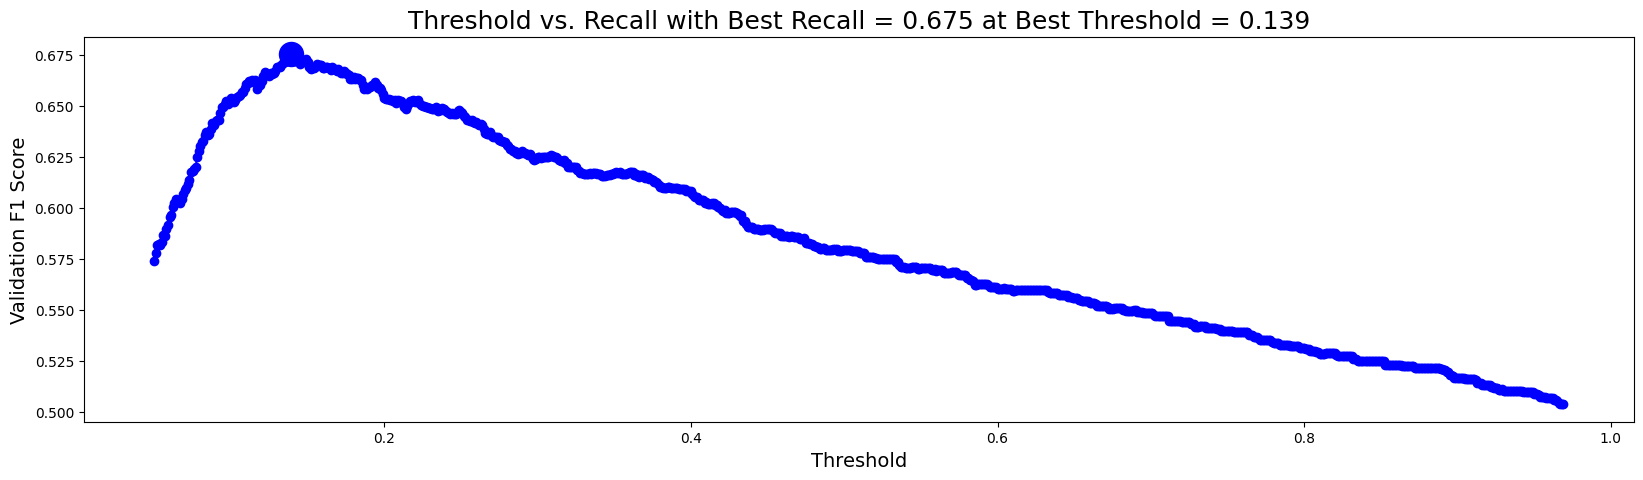

In [140]:
# PLOT THRESHOLD VS. Recall
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_recall], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. Recall with Best Recall = {best_score:.3f} at Best Threshold = {best_threshold_recall:.3}',size=18)
plt.show()

In [141]:
y_pred_metki_on_avg,y_pred_avg = preds_on_all_model(X_test,best_threshold_recall,models)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_metki_on_avg, average='macro')
roc = roc_auc_score(y_test, y_pred_avg)
print("AUC_ROC----"+str(roc))
print("F1-score-----"+str(f1))
print("Precision-----"+str(precision))
print("Recall-----"+str(recall))

AUC_ROC----0.7568222374742621
F1-score-----0.630753531338955
Precision-----0.639479194742189
Recall-----0.6846945778997942
